In [9]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
#from nistats.first_level_model import FirstLevelModel
#from nistats.second_level_model import SecondLevelModel
#from nistats.thresholding import map_threshold
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl
from plotting_utils import *

# t1w background image template
# mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
mni09c = '/home/scotti/projects/3t_7t_sst_comparison/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

<ipython-input-1-96db542b1232>:1: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  import nistats


# functions

In [11]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', model_n=0, thresholding=None, threshold_z=3.1, hp=False,
                          base_dir='../derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst',
                          from_working_dir=False, 
                          flame='1',dum_suffix=''):
    
    # Look-up dictionaries
    if model_n == 0:
        first_level_copes = {'fs': 0,
                             'ss': 1,
                             'go': 2,
                             'fs-go': 3,
                             'fs-ss': 4,
                             'ss-go': 5
                             }

#         second_level_copes = {'group_mean': 1,
#                               '-group_mean': 2,
#                               'SM-group_mean': 3,
#                               'SJSI-group_mean': 4,
#                               'aron-group_mean': 5,
#                               'openfmri-group_mean': 6
#                               }
        
        second_level_copes = {'group mean': 1,
                              '-group mean': 2,
                              'GdH mean': 3,
                              'SM mean': 4,
                              'SJSI mean': 5,
                              'aron mean': 6,
                              'openfmri mean': 7
                              }
        
    elif model_n == 1:
        first_level_copes = {'response_left': 0,
                             'response_right': 1,
                             'left-right': 2}

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]
    
    if hp:
        model_suffix = '_hp'
    else:
        model_suffix = ''

    if thresholding is None or thresholding == 'fdr':
        if from_working_dir:
            nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_sst_hp_alldatasets_timelockstopsignal/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_flame{flame}/flameo/stats/zstat{cope2}.nii.gz')
        else:
            nii = nib.load(this_contrast:=os.path.join(base_dir, f'fwhm-{fwhm}/model-{model_n}{model_suffix}{dum_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat.nii.gz'))
        
#         if cope2 not in [0, 1]:
#             nii = calculate_contrast(this_contrast, this_contrast.replace(f'grouplevelcontrast-{cope2}', 'grouplevelcontrast-1'))
        
        if thresholding is None:
            threshold = 0
        else:
            _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')
            
    elif thresholding == 'fwer' or thresholding == 'cluster':
        
        # if from_working_dir:
        #     nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_{run_mode}/flameo/stats/zstat{cope2}.nii.gz')        
        nii_pos = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))
        nii_neg = nib.load(os.path.join(base_dir, f'model-{model_n}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2+1}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))

        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nii_pos.get_fdata())
        

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1.3])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction=display_mode, n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax



In [12]:
# if calculating contrast post-glm
def calculate_contrast(contrast, groupmean):
    
    # SM - groupmean = x, SM = x + groupmean
    contrast_data = (contrast_load:=nib.load(contrast)).get_fdata()
    groupmean_data = nib.load(groupmean).get_fdata()
    
    this_contrast = nib.nifti1.Nifti1Image(contrast_data + groupmean_data, affine=contrast_load.affine)
    
    return this_contrast

## setup

In [4]:
# setup dirs
base_dir = '../derivatives/glm_feat_hp_sct_timelockstopsignal/group_level_model/all_datasets'
fwhm = 'base'

In [13]:
dum_suffix = ''

# Load MNI template
# Make background colour black
mni09c_load = nib.load(mni09c)
black_bg = mni09c_load.get_fdata()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=mni09c_load.affine)

# 6 event types, 6 contrasts
# FS - GO
fsgo_group_mean, thresh_fsgo_group_mean = get_second_level_zmap('fs-go', 'group mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsgo_neg_group_mean, thresh_fsgo_neg_group_mean = get_second_level_zmap('fs-go', '-group mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsgo_gdh_mean, thresh_fsgo_SM_mean = get_second_level_zmap('fs-go', 'GdH mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsgo_SM_mean, thresh_fsgo_SM_mean = get_second_level_zmap('fs-go', 'SM mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsgo_SJSI_mean, thresh_fsgo_SJSI_mean = get_second_level_zmap('fs-go', 'SJSI mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsgo_aron_mean, thresh_fsgo_aron_mean = get_second_level_zmap('fs-go', 'aron mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsgo_openfmri_mean, thresh_fsgo_openfmri_mean = get_second_level_zmap('fs-go', 'openfmri mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)

# # SS - GO
ssgo_group_mean, thresh_ssgo_group_mean = get_second_level_zmap('ss-go', 'group mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
ssgo_neg_group_mean, thresh_ssgo_neg_group_mean = get_second_level_zmap('ss-go', '-group mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
ssgo_gdh_mean, thresh_ssgo_SM_mean = get_second_level_zmap('ss-go', 'GdH mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
ssgo_SM_mean, thresh_ssgo_SM_mean = get_second_level_zmap('ss-go', 'SM mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
ssgo_SJSI_mean, thresh_ssgo_SJSI_mean = get_second_level_zmap('ss-go', 'SJSI mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
ssgo_aron_mean, thresh_ssgo_aron_mean = get_second_level_zmap('ss-go', 'aron mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
ssgo_openfmri_mean, thresh_ssgo_openfmri_mean = get_second_level_zmap('ss-go', 'openfmri mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)

# # FS - SS
fsss_group_mean, thresh_fsss_group_mean = get_second_level_zmap('fs-ss', 'group mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsss_neg_group_mean, thresh_fsss_neg_group_mean = get_second_level_zmap('fs-ss', '-group mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsss_gdh_mean, thresh_fsss_SM_mean = get_second_level_zmap('fs-ss', 'GdH mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsss_SM_mean, thresh_fsss_SM_mean = get_second_level_zmap('fs-ss', 'SM mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsss_SJSI_mean, thresh_fsss_SJSI_mean = get_second_level_zmap('fs-ss', 'SJSI mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsss_aron_mean, thresh_fsss_aron_mean = get_second_level_zmap('fs-ss', 'aron mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)
fsss_openfmri_mean, thresh_fsss_openfmri_mean = get_second_level_zmap('fs-ss', 'openfmri mean', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir, flame='12', dum_suffix=dum_suffix)

zmaps_fsgo = [fsgo_aron_mean,fsgo_openfmri_mean,fsgo_gdh_mean,fsgo_SJSI_mean,fsgo_SM_mean]
zmaps_ssgo = [ssgo_aron_mean,ssgo_openfmri_mean,ssgo_gdh_mean,ssgo_SJSI_mean,ssgo_SM_mean]
zmaps_fsss = [fsss_aron_mean,fsss_openfmri_mean,fsss_gdh_mean,fsss_SJSI_mean,fsss_SM_mean]
groupmeans = [fsgo_group_mean,fsss_group_mean,ssgo_group_mean]


# PLOT

## FWHM -> base

## FS - GO

ExpiredDeprecationError: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Raises <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

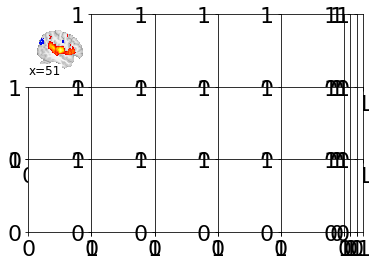

In [14]:
# plot t maps for smoothed images
fontsize = 22
vmax = 10
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_fsgo) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_fsgo)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_fsgo)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_fsgo, 
                          roi_dict=get_roi_dict(),
                          z_threshold=3.1,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG','STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2,3,4),
                          annotate=True, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
f.suptitle('FS > GO')
axes[0,0].set_title('Aron_3T')
axes[0,1].set_title('Poldrack_3T')
axes[0,2].set_title('deHollander_7T')
axes[0,3].set_title('Isherwood_7T')
axes[0,4].set_title('Miletic_7T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../figures/figures_for_paper/individual_dataset_glm_wholebrain_fs-go_supplementary_material.pdf', bbox_inches='tight')
# f.savefig('../figures/figures_for_paper/individual_dataset_glm_wholebrain_fs-go_supplementary_material.png', bbox_inches='tight', dpi = 300)
# f.savefig('../figures/figures_for_paper/individual_dataset_glm_wholebrain_fs-go_supplementary_material.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

## FS - SS

/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


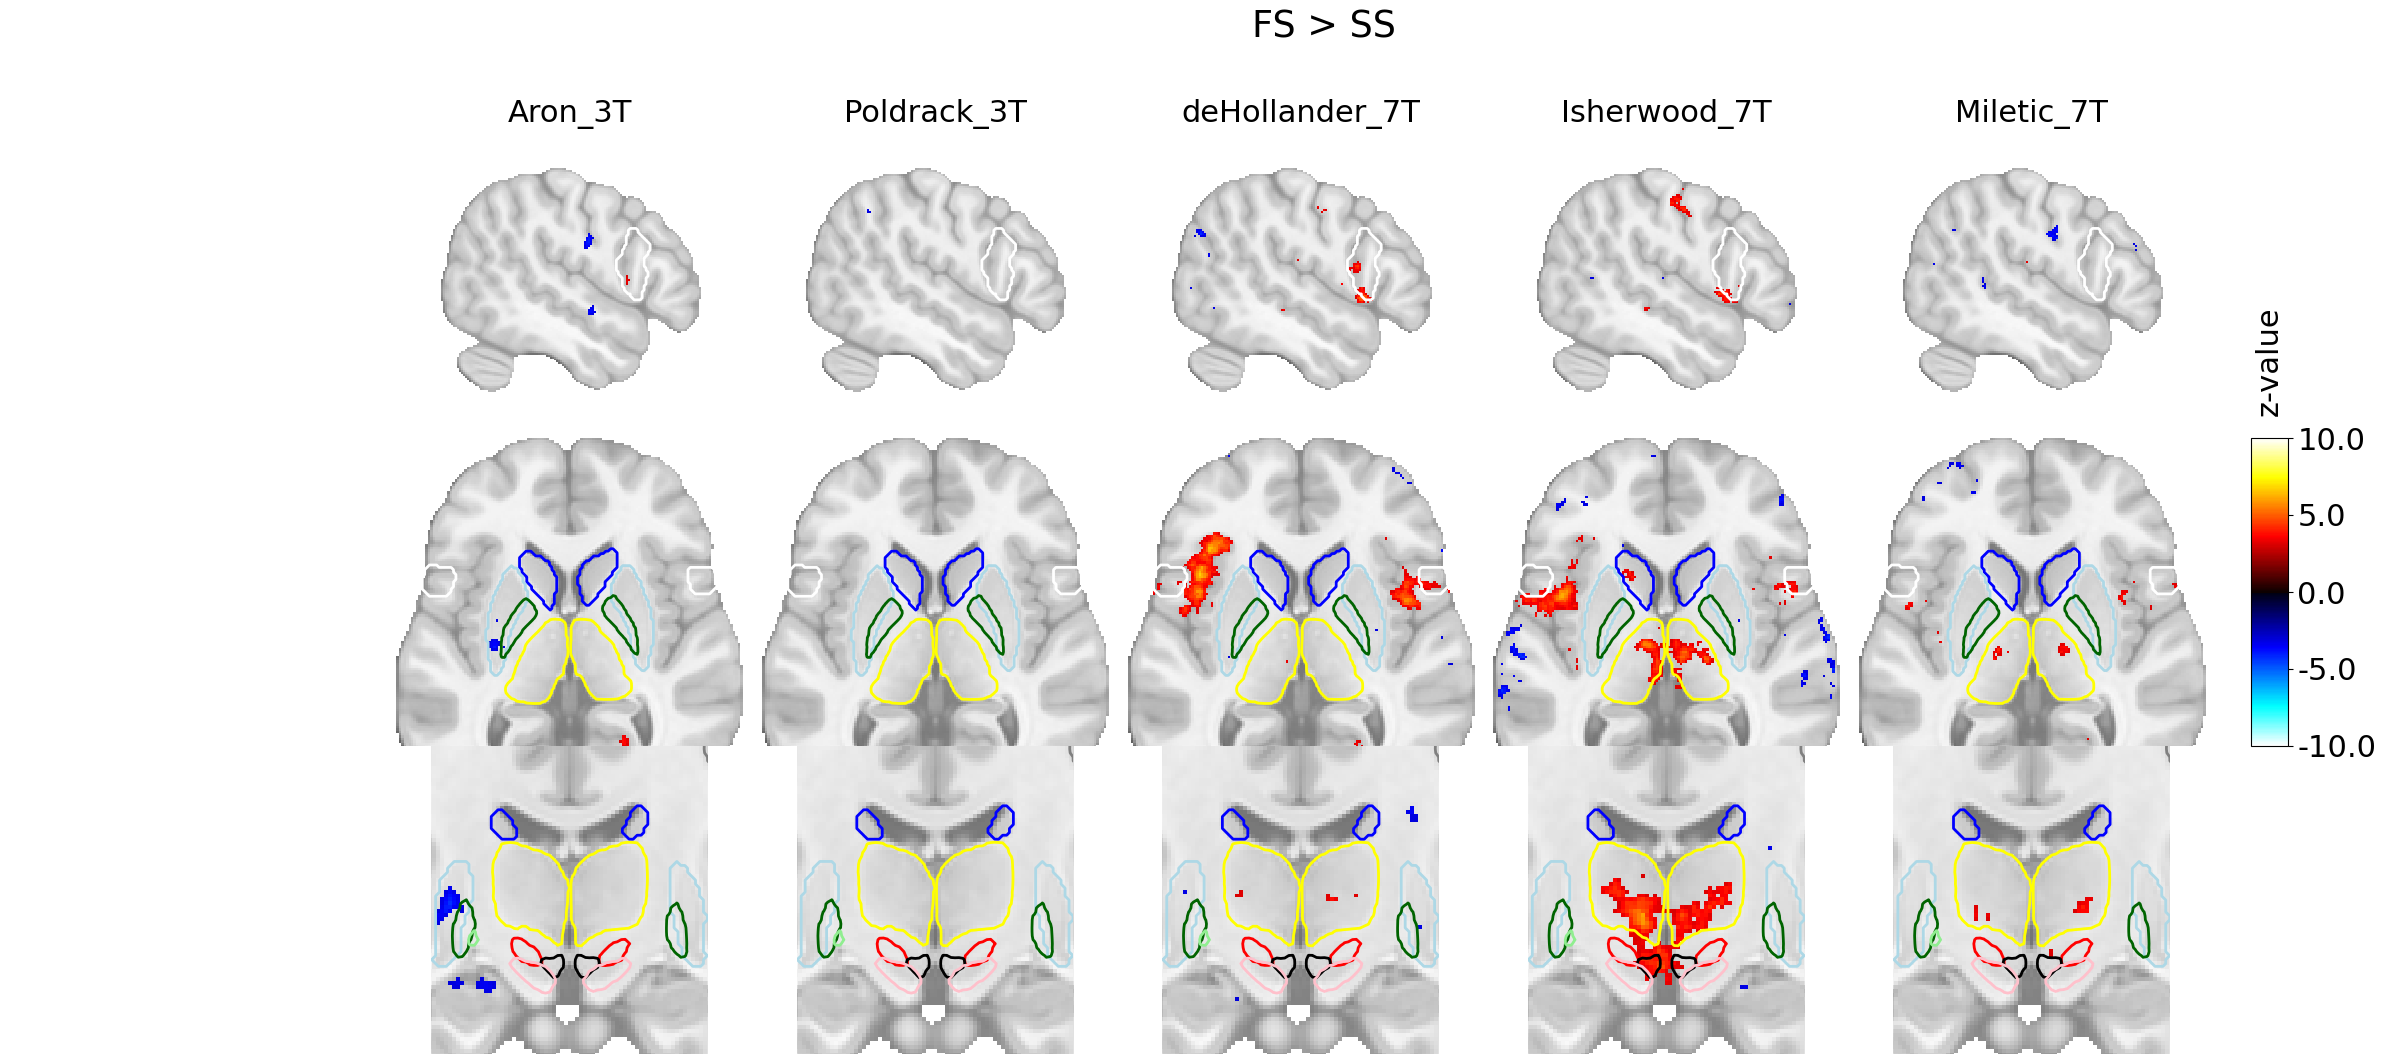

In [7]:
# plot t maps for smoothed images
fontsize = 22
vmax = 10
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_fsss) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_fsss)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_fsss)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_fsss, 
                          roi_dict=get_roi_dict(),
                          z_threshold=3.1,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
f.suptitle('FS > SS')
axes[0,0].set_title('Aron_3T')
axes[0,1].set_title('Poldrack_3T')
axes[0,2].set_title('deHollander_7T')
axes[0,3].set_title('Isherwood_7T')
axes[0,4].set_title('Miletic_7T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../figures/figures_for_paper/individual_dataset_glm_wholebrain_fs-ss_supplementary_material.pdf', bbox_inches='tight')
# f.savefig('../figures/figures_for_paper/individual_dataset_glm_wholebrain_fs-ss_supplementary_material.png', bbox_inches='tight', dpi = 300)
# f.savefig('../figures/figures_for_paper/individual_dataset_glm_wholebrain_fs-ss_supplementary_material.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

## SS - GO

/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


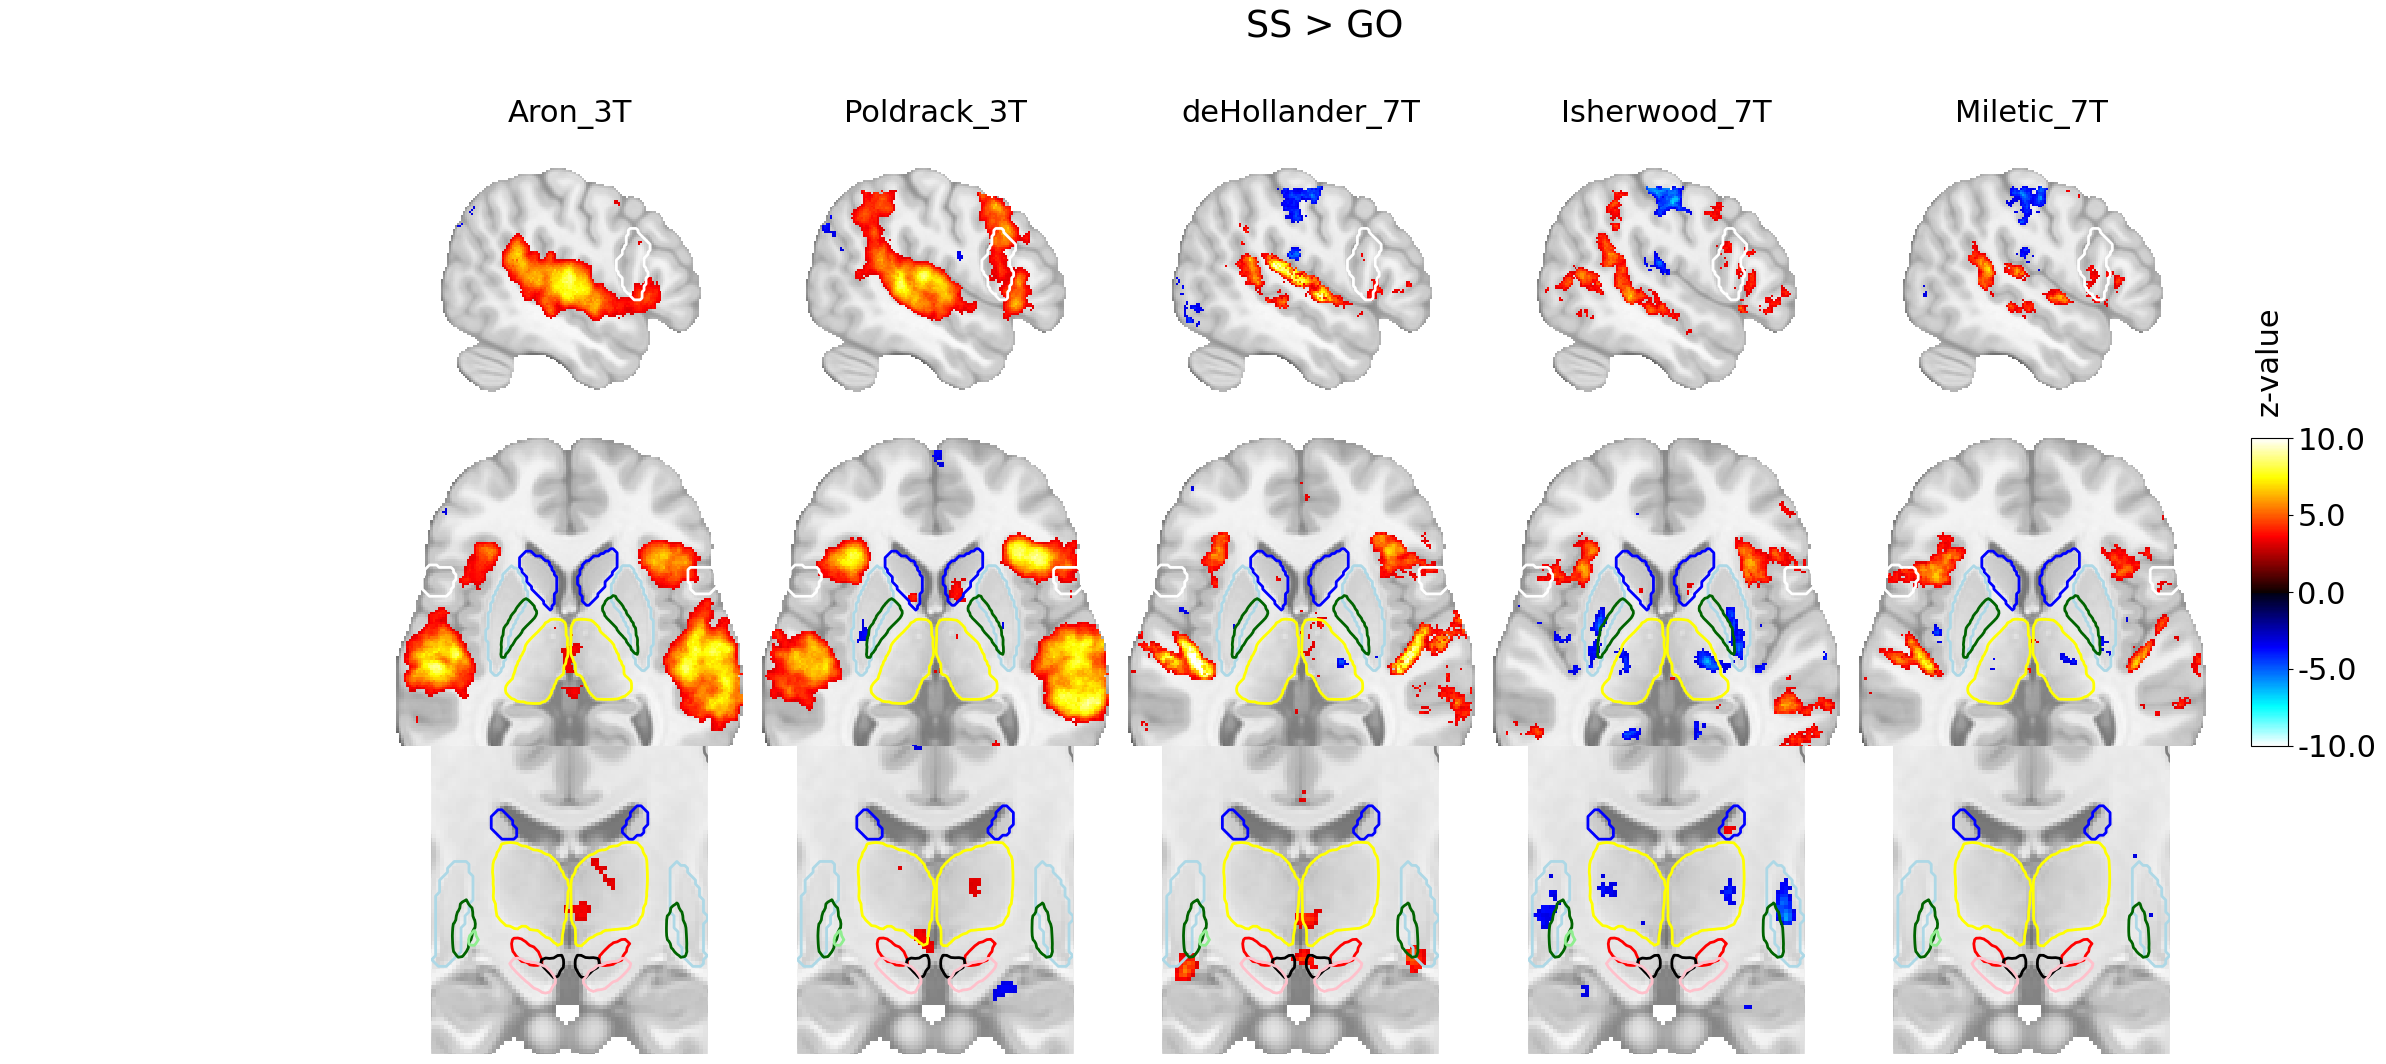

In [8]:
# plot t maps for smoothed images
fontsize = 22
vmax = 10
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps_ssgo) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_ssgo)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_ssgo)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_ssgo, 
                          roi_dict=get_roi_dict(),
                          z_threshold=3.1,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2,3,4,5),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
f.suptitle('SS > GO')
axes[0,0].set_title('Aron_3T')
axes[0,1].set_title('Poldrack_3T')
axes[0,2].set_title('deHollander_7T')
axes[0,3].set_title('Isherwood_7T')
axes[0,4].set_title('Miletic_7T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../figures/figures_for_paper/individual_dataset_glm_wholebrain_ss-go_supplementary_material.pdf', bbox_inches='tight')
# f.savefig('../figures/figures_for_paper/individual_dataset_glm_wholebrain_ss-go_supplementary_material.png', bbox_inches='tight', dpi = 300)
# f.savefig('../figures/figures_for_paper/individual_dataset_glm_wholebrain_ss-go_supplementary_material.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

# group means all contrasts

/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

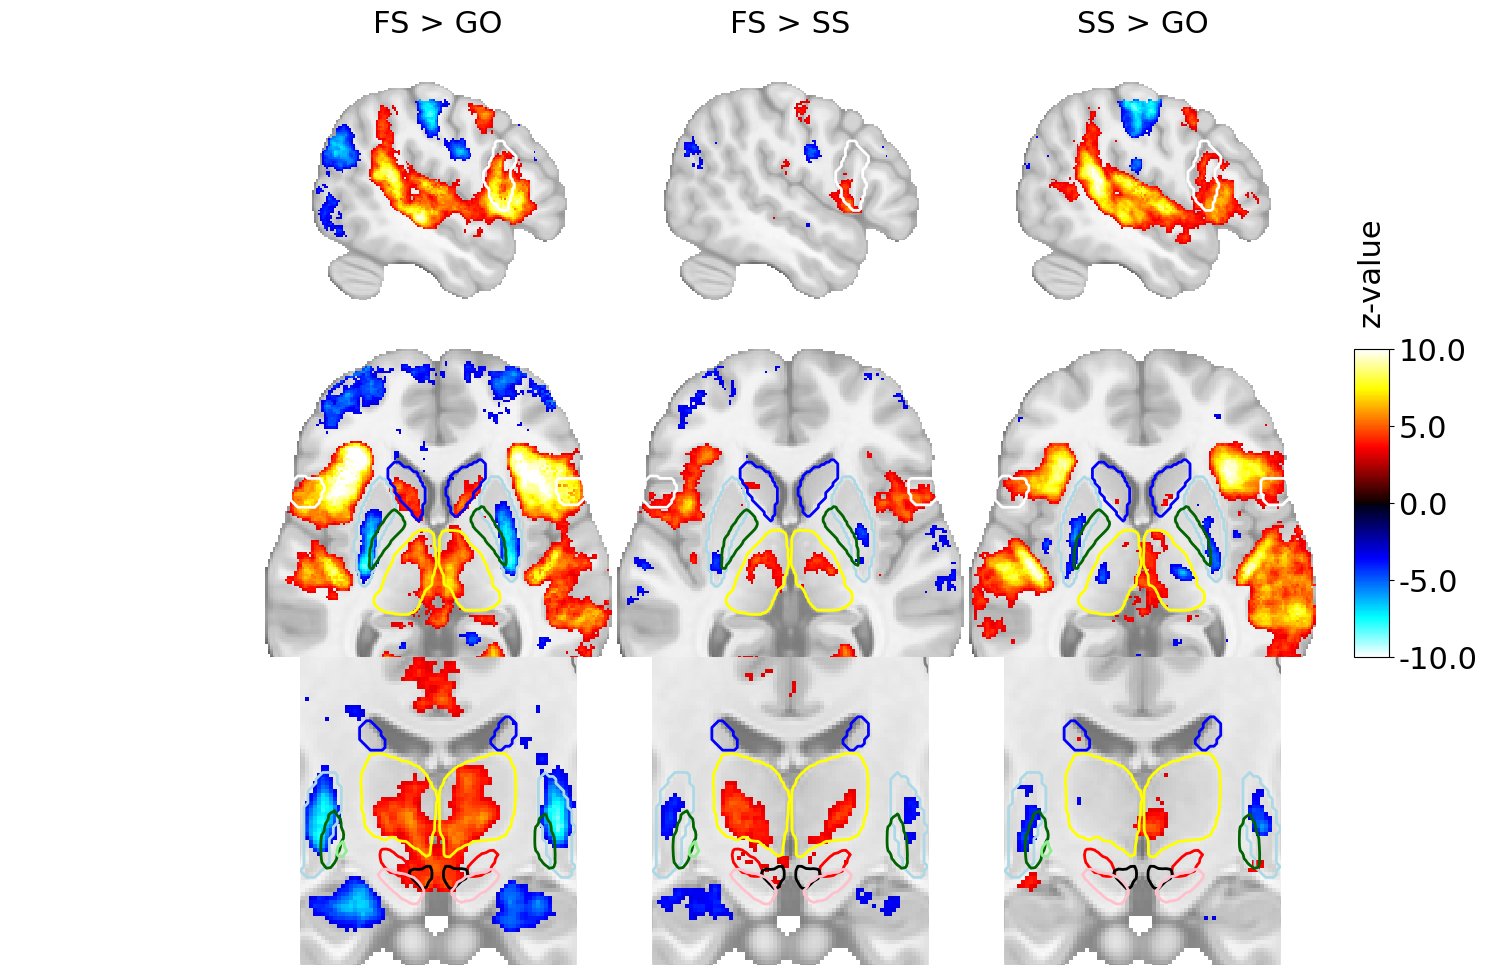

In [9]:
# plot t maps for smoothed images
fontsize = 22
vmax = 10
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(groupmeans) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(groupmeans)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(groupmeans)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(groupmeans, 
                          roi_dict=get_roi_dict(),
                          z_threshold=3.1,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2,3),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('FS > GO')
axes[0,1].set_title('FS > SS')
axes[0,2].set_title('SS > GO')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## update plotting, we can do better

(well, more specifically, steven can do better..)

In [15]:
from nilearn import plotting
def draw_custom_colorbar(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True,
                         format="%.1f", cmap=plotting.cm.cold_hot, tick_left=True, tick_right=False, is_symmetric=True):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = cmap
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    
    if nb_ticks > 0:
        ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    else:
        ticks = []
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    if is_symmetric:
        norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation='vertical', cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format=format)
    
    if flip:
        colorbar_ax.invert_yaxis()
    if tick_left:
        colorbar_ax.yaxis.tick_left()
    if tick_right:
        colorbar_ax.yaxis.tick_right()

    return colorbar_ax

def add_contours(disp, roi, color='white', linewidth=1, thr=0.3, **kwargs):
    from nilearn._utils.extmath import fast_abs_percentile
    from nilearn._utils.param_validation import check_threshold
    if not isinstance(roi, nib.Nifti1Image):
        map_img = nib.load(roi)
    else:
        map_img = roi
    data = map_img.get_fdata()
    
    # manually threhsold image
    data[data < thr] = 0
    
    # then determine the plotting threshold - this is a different value, required for plotting reasons,
    # and finds the percentile of the data that corresponds to the threshold
#     thr = check_threshold(thr, data,
#                           percentile_func=fast_abs_percentile,
#                           name='threshold')
    
    # Get rid of background values in all cases
    thr = max(thr, 1e-6)
    disp.add_contours(nib.Nifti1Image(data, map_img.affine), levels=[thr], linewidths=linewidth, colors=[color], **kwargs)
    
def get_roi_dict():
    # make dict of masks & filenames in 09c-space, get colors
    fns = glob.glob('../sourcedata/masks/mni_and_thal/space*')
    fns = glob.glob('../sourcedata/masks/inhibition_redefined_masks/space*')
    fns.sort()
    names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_label-(?P<label>[a-zA-Z0-9]+)_probseg.nii.gz', fn).groupdict()['label'] for fn in fns]
    roi_dict = dict(zip(names, fns))
    for mask, fn in roi_dict.items():
        roi_dict[mask] = {}
        roi_dict[mask]['fn'] = fn
        roi_dict[mask]['color'] = get_color(mask)
        roi_dict[mask]['threshold'] = 0.3
    return roi_dict

In [16]:
roi_dict = get_roi_dict()
# rois_ = ['IFG','SN','STN','GPe','VTA','STR','GPi']
rois_ = ['IFG','SN','STN','GPe','VTA','GPi','preSMA','M1','Caudate','Putamen', 'Tha']
rois_hemi = [item for items in [('l'+x,'r'+x) for x in rois_] for item in items]
# rois_hemi = rois_hemi + ['THA']
rois_hemi

['lIFG',
 'rIFG',
 'lSN',
 'rSN',
 'lSTN',
 'rSTN',
 'lGPe',
 'rGPe',
 'lVTA',
 'rVTA',
 'lGPi',
 'rGPi',
 'lpreSMA',
 'rpreSMA',
 'lM1',
 'rM1',
 'lCaudate',
 'rCaudate',
 'lPutamen',
 'rPutamen',
 'lTha',
 'rTha']

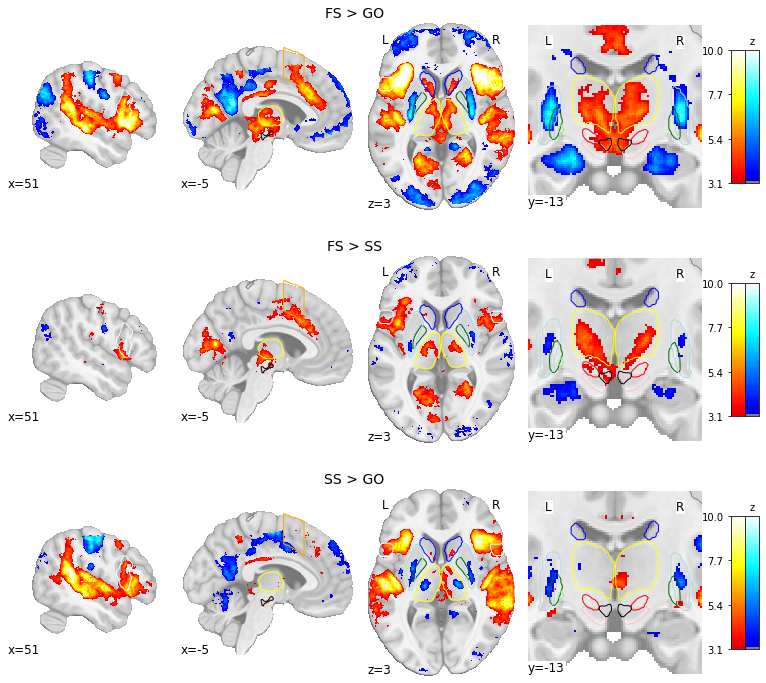

In [18]:
font = {'size': 10}
lines = {'linewidth': 0.5}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
f = plt.figure(figsize=(14,12))
gridspec = f.add_gridspec(ncols=2, nrows=3, 
                          hspace=0.25, wspace=0.0, 
                          width_ratios=[8,1])
ax0 = f.add_subplot(gridspec[0,0])
ax0.axis('off')
ax0.set_title('FS > GO', fontsize=14)

ax1 = f.add_subplot(gridspec[1,0])
ax1.axis('off')
ax1.set_title('FS > SS', fontsize=14)

ax2 = f.add_subplot(gridspec[2,0])
ax2.axis('off')
ax2.set_title('SS > GO', fontsize=14)

## fs - go
gs00 = gridspec[0,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([thresh_fsgo_group_mean, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs00[i]), black_bg=False, threshold=0.01)
    d.add_overlay(fsgo_group_mean, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
    if display_mode == 'y':
        for cut_ax in d.axes.values():
            cut_ax.ax.set_xlim(-39, 39)
            cut_ax.ax.set_ylim(-40, 42)
    # ROIs
    for roi_ in rois_hemi:
        roi_map = roi_dict[roi_]
        add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

# colorbar
gs01 = gridspec[0,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

## fs - ss
gs10 = gridspec[1,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([thresh_fsss_group_mean, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs10[i]), black_bg=False, threshold=0.01)
    d.add_overlay(fsss_group_mean, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
    if display_mode == 'y':
        for cut_ax in d.axes.values():
            cut_ax.ax.set_xlim(-39, 39)
            cut_ax.ax.set_ylim(-40, 42)
    # ROIs
    for roi_ in rois_hemi:
        roi_map = roi_dict[roi_]
        add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])
# colorbar
gs11 = gridspec[1,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

# ss - go
gs30 = gridspec[2,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([thresh_ssgo_group_mean, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs30[i]), black_bg=False, threshold=0.01)
    d.add_overlay(ssgo_group_mean, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
    if display_mode == 'y':
        for cut_ax in d.axes.values():
            cut_ax.ax.set_xlim(-39, 39)
            cut_ax.ax.set_ylim(-40, 42)
    # ROIs
    for roi_ in rois_hemi:
        roi_map = roi_dict[roi_]
        add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])
# colorbar
gs31 = gridspec[2,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs31[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs31[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

f.savefig('../figures/figures_for_paper/main_group_level_glm_wholebrain_timelockstopsignal_all_contrasts.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/main_group_level_glm_wholebrain_timelockstopsignal_all_contrasts.png', bbox_inches='tight', dpi = 300)
f.savefig('../figures/figures_for_paper/main_group_level_glm_wholebrain_timelockstopsignal_all_contrasts.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

/tmp/ipykernel_1330731/1480596133.py:48: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = map_img.get_data()


Text(0.5, 1.0, 'z')

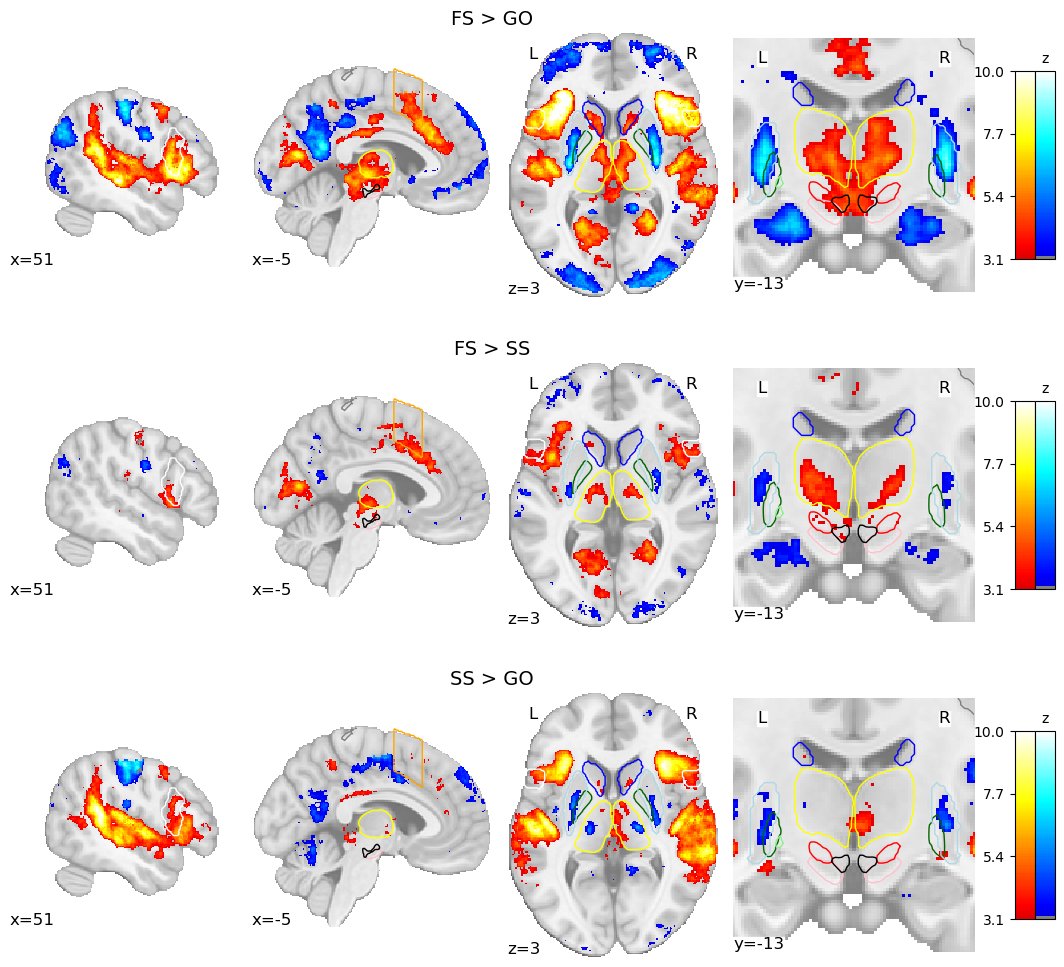

In [13]:
# font = {'size': 10}
# lines = {'linewidth': 0.5}
# import matplotlib
# matplotlib.rc('font', **font)
# matplotlib.rc('lines', **lines)
# f = plt.figure(figsize=(14,12))
# gridspec = f.add_gridspec(ncols=2, nrows=3, 
#                           hspace=0.25, wspace=0.0, 
#                           width_ratios=[8,1])
# ax0 = f.add_subplot(gridspec[0,0])
# ax0.axis('off')
# ax0.set_title('FS > GO', fontsize=14)

# ax1 = f.add_subplot(gridspec[1,0])
# ax1.axis('off')
# ax1.set_title('FS > SS', fontsize=14)

# ax2 = f.add_subplot(gridspec[2,0])
# ax2.axis('off')
# ax2.set_title('SS > GO', fontsize=14)

# ## fs - go
# gs00 = gridspec[0,0].subgridspec(1, 4, hspace=0, wspace=0)
# vmax_, threshold_ = 10, np.max([thresh_fsgo_group_mean, 3.1])
# for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
#     d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs00[i]), black_bg=False, threshold=0.01)
#     d.add_overlay(fsgo_group_mean, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
#     if display_mode == 'y':
#         for cut_ax in d.axes.values():
#             cut_ax.ax.set_xlim(-39, 39)
#             cut_ax.ax.set_ylim(-40, 42)
#     # ROIs
#     for roi_ in rois_hemi:
#         roi_map = roi_dict[roi_]
#         add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

# # colorbar
# gs01 = gridspec[0,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
# cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,1]), 
#                                 truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
# cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,2]), 
#                                 truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
# cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

# ## fs - ss
# gs10 = gridspec[1,0].subgridspec(1, 4, hspace=0, wspace=0)
# vmax_, threshold_ = 10, np.max([thresh_fsss_group_mean, 3.1])
# for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
#     d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs10[i]), black_bg=False, threshold=0.01)
#     d.add_overlay(fsss_group_mean, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
#     if display_mode == 'y':
#         for cut_ax in d.axes.values():
#             cut_ax.ax.set_xlim(-39, 39)
#             cut_ax.ax.set_ylim(-40, 42)
#     # ROIs
#     for roi_ in rois_hemi:
#         roi_map = roi_dict[roi_]
#         add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])
# # colorbar
# gs11 = gridspec[1,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
# cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,1]), 
#                                 truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
# cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,2]), 
#                                 truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
# cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

# # ss - go
# gs30 = gridspec[2,0].subgridspec(1, 4, hspace=0, wspace=0)
# vmax_, threshold_ = 10, np.max([thresh_ssgo_group_mean, 3.1])
# for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
#     d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs30[i]), black_bg=False, threshold=0.01)
#     d.add_overlay(ssgo_group_mean, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
#     if display_mode == 'y':
#         for cut_ax in d.axes.values():
#             cut_ax.ax.set_xlim(-39, 39)
#             cut_ax.ax.set_ylim(-40, 42)
#     # ROIs
#     for roi_ in rois_hemi:
#         roi_map = roi_dict[roi_]
#         add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])
# # colorbar
# gs31 = gridspec[2,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
# cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs31[1,1]), 
#                                 truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
# cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs31[1,2]), 
#                                 truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
# cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')


# get clusters

In [30]:
from nilearn.reporting import get_clusters_table
table = get_clusters_table(fsgo_group_mean, stat_threshold=3.1,
                           cluster_threshold=20)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-32.0,25.0,9.0,13.237948,45510
1,1a,-30.0,21.0,-10.0,12.417809,
2,1b,-33.0,28.0,2.0,12.312587,
3,1c,-30.0,23.0,-9.0,11.831738,
4,2,30.0,23.0,-13.0,12.128199,57516
5,2a,42.0,19.0,-1.0,11.791739,
6,2b,34.0,26.0,7.0,11.714393,
7,2c,62.0,-43.0,13.0,11.515741,
8,3,6.0,28.0,33.0,9.211617,16559
9,3a,-9.0,27.0,26.0,8.727012,


# look at 5mm smoothing

In [13]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap_5mm(first_level_contrast, second_level_contrast, fwhm='5p0', model_n=0, thresholding=None, threshold_z=3.1, hp=False,
                          base_dir='../derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst',
                          from_working_dir=False, 
                          flame='1',dum_suffix=''):
    
    # Look-up dictionaries
    if model_n == 0:
        first_level_copes = {'fs': 0,
                             'ss': 1,
                             'go': 2,
                             'fs-go': 3,
                             'fs-ss': 4,
                             'ss-go': 5
                             }

#         second_level_copes = {'group_mean': 1,
#                               '-group_mean': 2,
#                               'SM-group_mean': 3,
#                               'SJSI-group_mean': 4,
#                               'aron-group_mean': 5,
#                               'openfmri-group_mean': 6
#                               }
        
        second_level_copes = {'group mean': 1,
                              '-group mean': 2,
                              'GdH mean': 3,
                              'SM mean': 4,
                              'SJSI mean': 5,
                              'aron mean': 6,
                              'openfmri mean': 7
                              }
        
    elif model_n == 1:
        first_level_copes = {'response_left': 0,
                             'response_right': 1,
                             'left-right': 2}

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]
    
    if hp:
        model_suffix = '_hp'
    else:
        model_suffix = ''

    if thresholding is None or thresholding == 'fdr':
        if from_working_dir:
            nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_sstmsit_hp/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_flame{flame}/flameo/stats/zstat{cope2}.nii.gz')
        else:
            nii = nib.load(this_contrast:=os.path.join(base_dir, f'model-{model_n}{model_suffix}{dum_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat.nii.gz'))
        
#         if cope2 not in [0, 1]:
#             nii = calculate_contrast(this_contrast, this_contrast.replace(f'grouplevelcontrast-{cope2}', 'grouplevelcontrast-1'))
        
        if thresholding is None:
            threshold = 0
        else:
            _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')
            
    elif thresholding == 'fwer' or thresholding == 'cluster':
        
        # if from_working_dir:
        #     nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_{run_mode}/flameo/stats/zstat{cope2}.nii.gz')        
        nii_pos = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))
        nii_neg = nib.load(os.path.join(base_dir, f'model-{model_n}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2+1}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))

        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nii_pos.get_fdata())
        

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1.3])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction=display_mode, n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax



In [14]:
# setup dirs
base_dir_5p0 = '../derivatives/glm_feat_hp_sct/group_level_model/all_datasets/fwhm-5p0'
base_dir_base = '../derivatives/glm_feat_hp_sct/group_level_model/all_datasets'
fwhm_5p0 = '5p0'
fwhm_base = 'base'
dum_suffix = ''


In [15]:
# Load MNI template
# Make background colour black
mni09c_load = nib.load(mni09c)
black_bg = mni09c_load.get_fdata()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=mni09c_load.affine)

# 6 event types, 6 contrasts
# FS - GO
fsgo_group_mean_5p0, thresh_fsgo_group_mean_5p0 = get_second_level_zmap_5mm('fs-go', 'group mean', fwhm=fwhm_5p0, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir_5p0, flame='12', dum_suffix=dum_suffix)
fsgo_group_mean_base, thresh_fsgo_group_mean_base = get_second_level_zmap('fs-go', 'group mean', fwhm=fwhm_base, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir_base, flame='12', dum_suffix=dum_suffix)

# # SS - GO
ssgo_group_mean_5p0, thresh_ssgo_group_mean_5p0 = get_second_level_zmap_5mm('ss-go', 'group mean', fwhm=fwhm_5p0, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir_5p0, flame='12', dum_suffix=dum_suffix)
ssgo_group_mean_base, thresh_ssgo_group_mean_base = get_second_level_zmap('ss-go', 'group mean', fwhm=fwhm_base, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir_base, flame='12', dum_suffix=dum_suffix)

# # FS - SS
fsss_group_mean_5p0, thresh_fsss_group_mean_5p0 = get_second_level_zmap_5mm('fs-ss', 'group mean', fwhm=fwhm_5p0, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir_5p0, flame='12', dum_suffix=dum_suffix)
fsss_group_mean_base, thresh_fsss_group_mean_base = get_second_level_zmap('fs-ss', 'group mean', fwhm=fwhm_base, thresholding='fdr',model_n=0,from_working_dir=False, base_dir=base_dir_base, flame='12', dum_suffix=dum_suffix)

# groupmeans_5p0 = [fsgo_group_mean_5p0,fsss_group_mean_5p0,ssgo_group_mean_5p0]

/tmp/ipykernel_3495039/2002927339.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  black_bg = mni09c_load.get_data()


In [16]:
roi_dict = get_roi_dict()
# rois_ = ['IFG','SN','STN','GPe','VTA','STR','GPi']
rois_ = ['IFG','SN','STN','GPe','VTA','GPi','preSMA','M1','Caudate','Putamen', 'Tha']
rois_hemi = [item for items in [('l'+x,'r'+x) for x in rois_] for item in items]

/tmp/ipykernel_3495039/1480596133.py:48: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = map_img.get_data()
/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


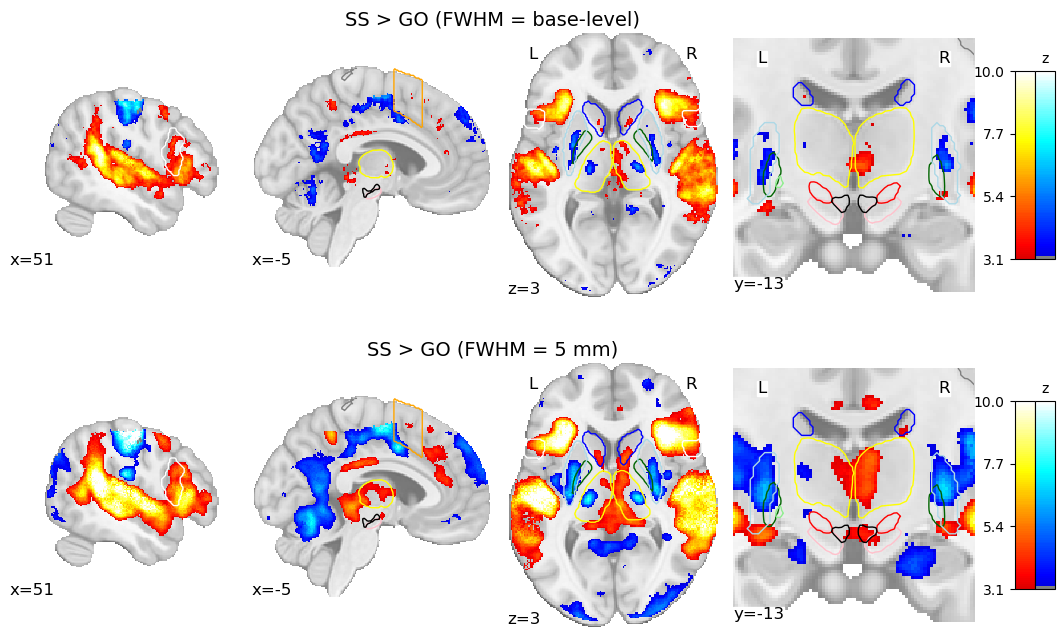

In [17]:
# ss > go

font = {'size': 10}
lines = {'linewidth': 0.5}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
f = plt.figure(figsize=(14,12))
gridspec = f.add_gridspec(ncols=2, nrows=3, 
                          hspace=0.25, wspace=0.0, 
                          width_ratios=[8,1])
ax0 = f.add_subplot(gridspec[0,0])
ax0.axis('off')
ax0.set_title('SS > GO (FWHM = base-level)', fontsize=14)

ax1 = f.add_subplot(gridspec[1,0])
ax1.axis('off')
ax1.set_title('SS > GO (FWHM = 5 mm)', fontsize=14)

# ax2 = f.add_subplot(gridspec[2,0])
# ax2.axis('off')
# ax2.set_title('SS > GO', fontsize=14)

## ss - go base
gs00 = gridspec[0,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([thresh_ssgo_group_mean_base, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs00[i]), black_bg=False, threshold=0.01)
    d.add_overlay(ssgo_group_mean_base, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
    if display_mode == 'y':
        for cut_ax in d.axes.values():
            cut_ax.ax.set_xlim(-39, 39)
            cut_ax.ax.set_ylim(-40, 42)
    # ROIs
    for roi_ in rois_hemi:
        roi_map = roi_dict[roi_]
        add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

# colorbar
gs01 = gridspec[0,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

## ss - go 5p0
gs10 = gridspec[1,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([thresh_ssgo_group_mean_5p0, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs10[i]), black_bg=False, threshold=0.01)
    d.add_overlay(ssgo_group_mean_5p0, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
    if display_mode == 'y':
        for cut_ax in d.axes.values():
            cut_ax.ax.set_xlim(-39, 39)
            cut_ax.ax.set_ylim(-40, 42)
    # ROIs
    for roi_ in rois_hemi:
        roi_map = roi_dict[roi_]
        add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])
# colorbar
gs11 = gridspec[1,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

f.savefig('../figures/figures_for_paper/ss-go_glm_smoothing_comparison.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ss-go_glm_smoothing_comparison.png', bbox_inches='tight', dpi = 300)
f.savefig('../figures/figures_for_paper/ss-go_glm_smoothing_comparison.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

/tmp/ipykernel_3495039/1480596133.py:48: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = map_img.get_data()
/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


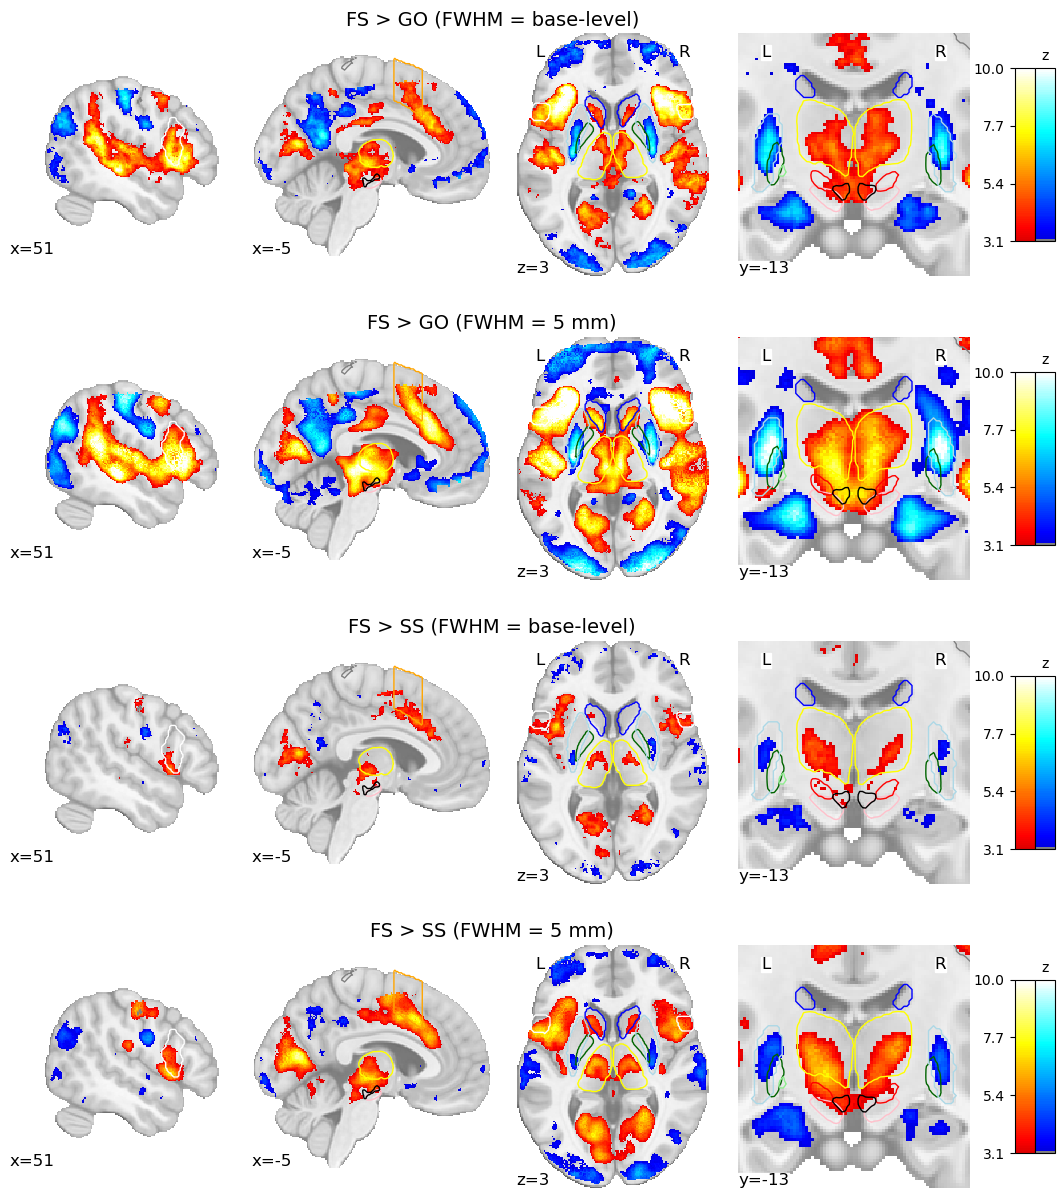

In [18]:
# fs > go & fs > ss

font = {'size': 10}
lines = {'linewidth': 0.5}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
f = plt.figure(figsize=(14,15))
gridspec = f.add_gridspec(ncols=2, nrows=4, 
                          hspace=0.25, wspace=0.0, 
                          width_ratios=[8,1])
ax0 = f.add_subplot(gridspec[0,0])
ax0.axis('off')
ax0.set_title('FS > GO (FWHM = base-level)', fontsize=14)

ax1 = f.add_subplot(gridspec[1,0])
ax1.axis('off')
ax1.set_title('FS > GO (FWHM = 5 mm)', fontsize=14)

ax2 = f.add_subplot(gridspec[2,0])
ax2.axis('off')
ax2.set_title('FS > SS (FWHM = base-level)', fontsize=14)

ax3 = f.add_subplot(gridspec[3,0])
ax3.axis('off')
ax3.set_title('FS > SS (FWHM = 5 mm)', fontsize=14)

# ax2 = f.add_subplot(gridspec[2,0])
# ax2.axis('off')
# ax2.set_title('SS > GO', fontsize=14)

## fs - go base
gs00 = gridspec[0,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([thresh_fsgo_group_mean_base, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs00[i]), black_bg=False, threshold=0.01)
    d.add_overlay(fsgo_group_mean_base, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
    if display_mode == 'y':
        for cut_ax in d.axes.values():
            cut_ax.ax.set_xlim(-39, 39)
            cut_ax.ax.set_ylim(-40, 42)
    # ROIs
    for roi_ in rois_hemi:
        roi_map = roi_dict[roi_]
        add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

# colorbar
gs01 = gridspec[0,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

## fs - go 5p0
gs10 = gridspec[1,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([thresh_fsgo_group_mean_5p0, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs10[i]), black_bg=False, threshold=0.01)
    d.add_overlay(fsgo_group_mean_5p0, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
    if display_mode == 'y':
        for cut_ax in d.axes.values():
            cut_ax.ax.set_xlim(-39, 39)
            cut_ax.ax.set_ylim(-40, 42)
    # ROIs
    for roi_ in rois_hemi:
        roi_map = roi_dict[roi_]
        add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])
# colorbar
gs11 = gridspec[1,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')





## fs - ss base
gs20 = gridspec[2,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([thresh_fsss_group_mean_base, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs20[i]), black_bg=False, threshold=0.01)
    d.add_overlay(fsss_group_mean_base, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
    if display_mode == 'y':
        for cut_ax in d.axes.values():
            cut_ax.ax.set_xlim(-39, 39)
            cut_ax.ax.set_ylim(-40, 42)
    # ROIs
    for roi_ in rois_hemi:
        roi_map = roi_dict[roi_]
        add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

# colorbar
gs21 = gridspec[2,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs21[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs21[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

## fs - ss 5p0
gs30 = gridspec[3,0].subgridspec(1, 4, hspace=0, wspace=0)
vmax_, threshold_ = 10, np.max([thresh_fsss_group_mean_5p0, 3.1])
for i, (display_mode, cut_coord) in enumerate(zip(['x', 'x', 'z', 'y'], [51, -5, 3, -13])):
    d = plotting.plot_anat(mni09c, cut_coords=[cut_coord], display_mode=display_mode, figure=f, axes=f.add_subplot(gs30[i]), black_bg=False, threshold=0.01)
    d.add_overlay(fsss_group_mean_5p0, threshold=threshold_, cmap=nilearn.plotting.cm.cold_hot, vmax=vmax_, vmin=-vmax_)
    if display_mode == 'y':
        for cut_ax in d.axes.values():
            cut_ax.ax.set_xlim(-39, 39)
            cut_ax.ax.set_ylim(-40, 42)
    # ROIs
    for roi_ in rois_hemi:
        roi_map = roi_dict[roi_]
        add_contours(d, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])
# colorbar
gs31 = gridspec[3,1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs31[1,1]), 
                                truncation_limits=(threshold_, vmax_), vmax=vmax_, offset=threshold_, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs31[1,2]), 
                                truncation_limits=(-threshold_,-vmax_), vmax=vmax_, offset=threshold_, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center')

f.savefig('../figures/figures_for_paper/fs-go_and_fs-ss_glm_smoothing_comparison_supplementary_material.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/fs-go_and_fs-ss_glm_smoothing_comparison_supplementary_material.png', bbox_inches='tight', dpi = 300)
f.savefig('../figures/figures_for_paper/fs-go_and_fs-ss_glm_smoothing_comparison_supplementary_material.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

In [20]:
import nipype
print(nipype.__version__)

230208-14:33:15,368 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.7.0
1.7.0


# --------------------- RANDOM CODE ---------------------

# all group means

In [9]:
all_means = [fsgo_group_mean,fsss_group_mean,ssgo_group_mean]

Text(0.5, 1.0, 'z-value')

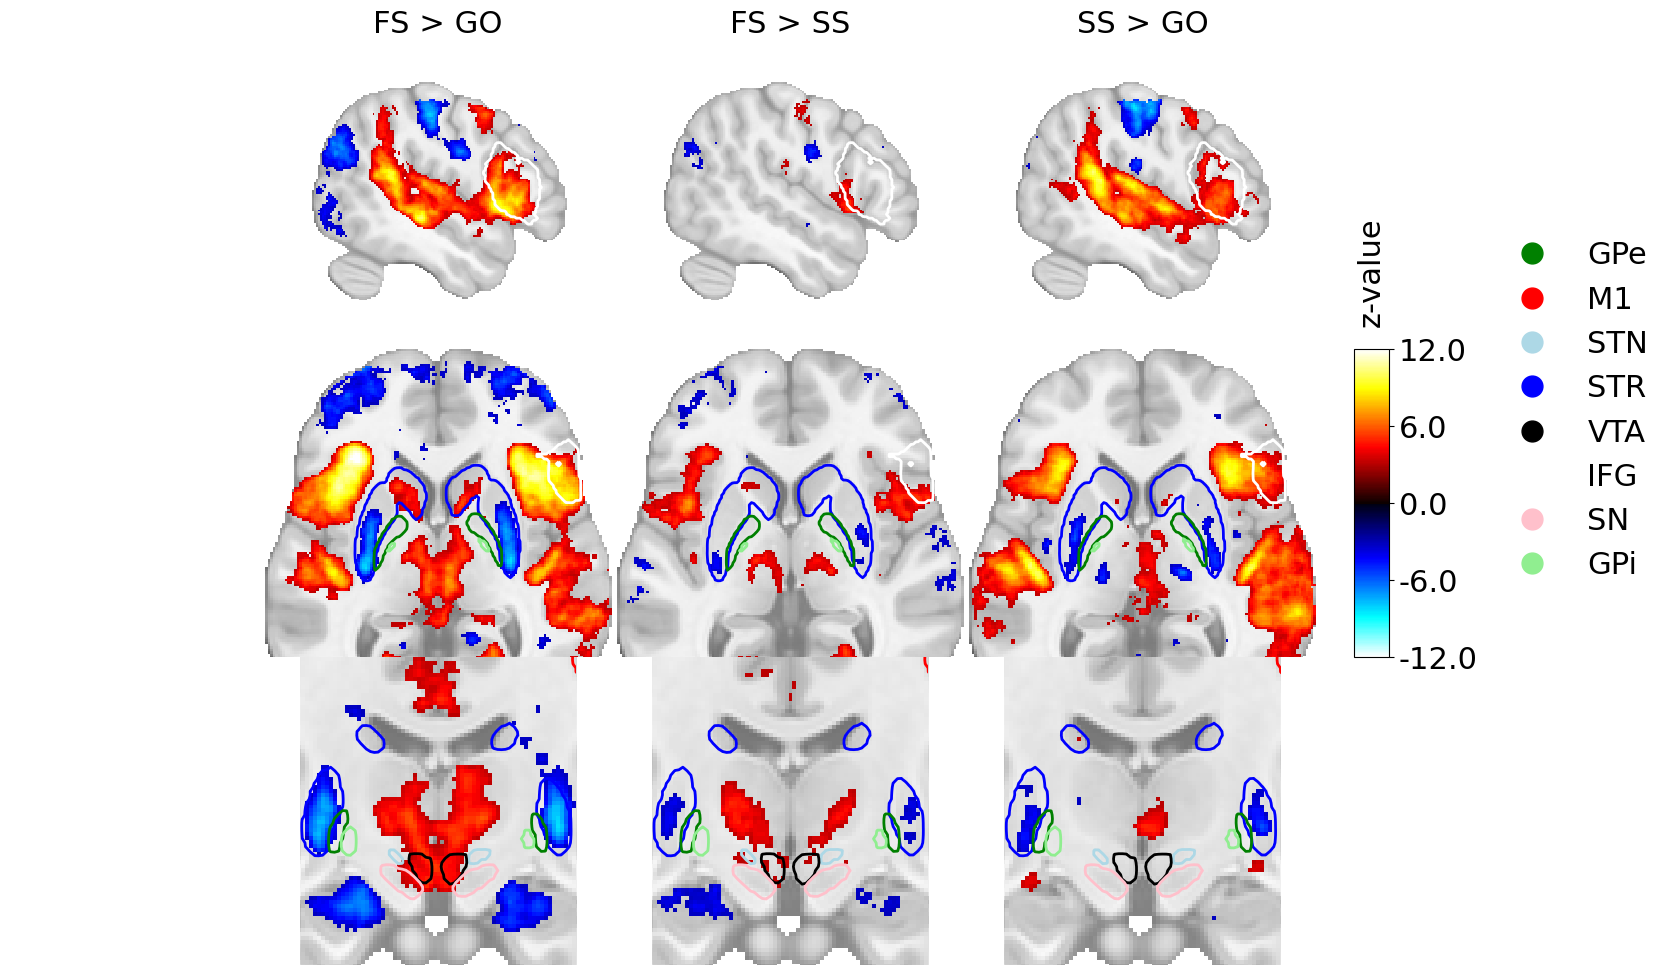

In [10]:
# plot t maps for smoothed images
fontsize = 22
vmax = 12
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(all_means) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(all_means)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(all_means)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(all_means, 
                          roi_dict=get_roi_dict(),
                          z_threshold=3.1,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('FS > GO')
axes[0,1].set_title('FS > SS')
axes[0,2].set_title('SS > GO')
# axes[0,3].set_title('Poldrack_3T')
# axes[0,4].set_title('Aron_3T')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

In [38]:
from nipype.utils.filemanip import loadpkl
res = loadpkl('/home/scotti/projects/3t_7t_sst_comparison/processing/nipype_workflow_folders/all_datasets/feat_level3_sst_hp_alldatasets/_contrast_n_0_fwhm_base_model_n_0/selector/result_selector.pklz')
res

In [40]:
res.outputs


level2_cope = ['/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leipzig_7T_GdH/sub-BI3T/func/fwhm-base/model-0/sub-BI3T_task-stop_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz', '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leipzig_7T_GdH/sub-FMFT/func/fwhm-base/model-0/sub-FMFT_task-stop_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz', '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leipzig_7T_GdH/sub-GAIT/func/fwhm-base/model-0/sub-GAIT_task-stop_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz', '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leipzig_7T_GdH/sub-KCAT/func/fwhm-base/model-0/sub-KCAT_task-stop_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz', '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leip

In [24]:
from nipype.utils.filemanip import loadpkl
res = loadpkl('/home/scotti/projects/3t_7t_sst_comparison/processing/nipype_workflow_folders/all_datasets/feat_level3_sst_hp_alldatasets/_contrast_n_0_fwhm_base_model_n_0/selector/result_selector.pklz')
res

In [25]:
res.outputs


level2_cope = ['/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leipzig_7T_GdH/sub-BI3T/func/fwhm-base/model-0/sub-BI3T_task-stop_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz', '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leipzig_7T_GdH/sub-FMFT/func/fwhm-base/model-0/sub-FMFT_task-stop_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz', '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leipzig_7T_GdH/sub-GAIT/func/fwhm-base/model-0/sub-GAIT_task-stop_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz', '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leipzig_7T_GdH/sub-KCAT/func/fwhm-base/model-0/sub-KCAT_task-stop_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz', '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_hp_sct/subject_level_model/Leip

In [20]:
res.